In [1]:
import os
import pickle
import math
import hmmlearn.hmm as hmm
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
import librosa
import seaborn as sns
from pydub import AudioSegment, effects
from scipy.io.wavfile import write, read

In [2]:
class_names = ['amluongmottram','amluongnammuoi', 'baitieptheo','baitruocdo','batnhac','dunglai','meimei','phatlaplai','phatngaunhien','phattuantu','tatam','tualui','tuatoi']
states = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dataset_path = 'dataset_final'
X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
model = {}
model_path = 'new_model_2'

In [3]:
def detect_leading_silence(sound, silence_threshold=-25.0, chunk_size=10):
        trim_ms = 0  

        assert chunk_size > 0  
        while sound[trim_ms:trim_ms + chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
            trim_ms += chunk_size

        return trim_ms

In [4]:
def get_mfcc(file_path):    
    trimmed_path = 'temp/trimmed.wav'
    sound = AudioSegment.from_file(file_path, format='wav')
    normalizedsound = effects.normalize(sound)
    normalizedsound.export(trimmed_path, format='wav')

    rate, data = read(trimmed_path)
    write(trimmed_path, rate, data)

    sound = AudioSegment.from_file(trimmed_path, format='wav')
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)
    print(file_path)
    print(str(start_trim) + " - " + str(duration - end_trim))

    trimmed_sound = sound[start_trim:duration - end_trim]
    trimmed_sound.export(trimmed_path, format='wav')


    y, sr = librosa.load(trimmed_path)  
    hop_length = math.floor(sr * 0.010)  
    win_length = math.floor(sr * 0.025)  
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, n_fft=1024,hop_length=hop_length, win_length=win_length)
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1))
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X = np.concatenate([mfcc, delta1, delta2], axis=0)  
    return X.T  

In [5]:
def print_avg_mfcc(all_data, class_names):
    for cname in class_names:
        max_len = 0
        for mfcc in all_data[cname]:
            if len(mfcc) > max_len:
                max_len = len(mfcc)
        all_padded_mfcc = []
        for mfcc in all_data[cname]:
            padded_mfcc = np.pad(mfcc, ((0, max_len - len(mfcc)), (0, 0)), mode='constant')
            all_padded_mfcc.append(padded_mfcc)
        avg_mfcc = np.mean(all_padded_mfcc, axis=0)
        fig, ax = plt.subplots()
        cax = ax.imshow(avg_mfcc.T, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
        ax.set_title(f"Average MFCC for {cname}")
        plt.show()


In [6]:
length = 0
for cn in class_names:
    length += len(os.listdir(f"{dataset_path}/{cn}"))
print('Total samples:', length)

all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
        os.path.join(dataset_path, cname)) if i.endswith('.wav')]
    data = [get_mfcc(file_path) for file_path in file_paths]
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]


Total samples: 835
dataset_final\amluongmottram\al100_minh0.wav
460 - 1450
dataset_final\amluongmottram\al100_minh1.wav
0 - 1500
dataset_final\amluongmottram\al100_minh10.wav
410 - 1270
dataset_final\amluongmottram\al100_minh11.wav
320 - 1160
dataset_final\amluongmottram\al100_minh12.wav
280 - 890
dataset_final\amluongmottram\al100_minh13.wav
310 - 1170
dataset_final\amluongmottram\al100_minh14.wav
20 - 1460
dataset_final\amluongmottram\al100_minh15.wav
660 - 1410
dataset_final\amluongmottram\al100_minh16.wav
0 - 1500
dataset_final\amluongmottram\al100_minh17.wav
0 - 1500
dataset_final\amluongmottram\al100_minh18.wav
0 - 1500
dataset_final\amluongmottram\al100_minh19.wav
0 - 1500
dataset_final\amluongmottram\al100_minh2.wav
460 - 1390
dataset_final\amluongmottram\al100_minh20.wav
0 - 1500
dataset_final\amluongmottram\al100_minh21.wav
0 - 1500
dataset_final\amluongmottram\al100_minh3.wav
440 - 1250
dataset_final\amluongmottram\al100_minh4.wav
370 - 1230
dataset_final\amluongmottram\al10

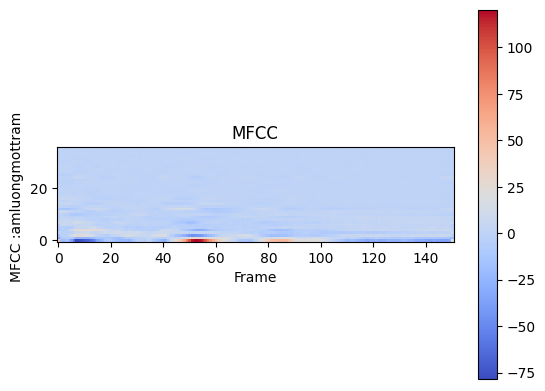

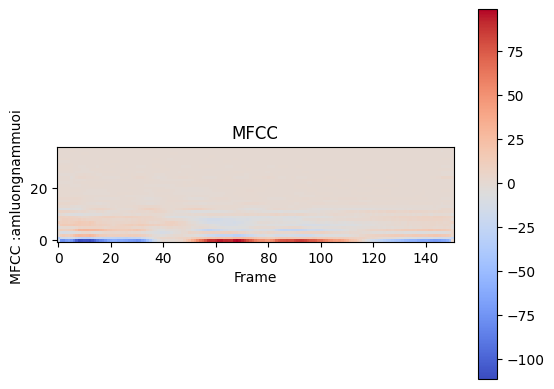

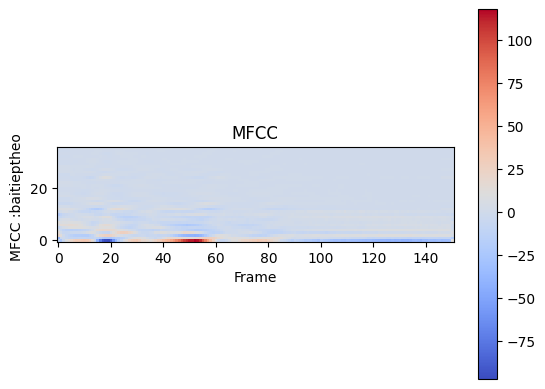

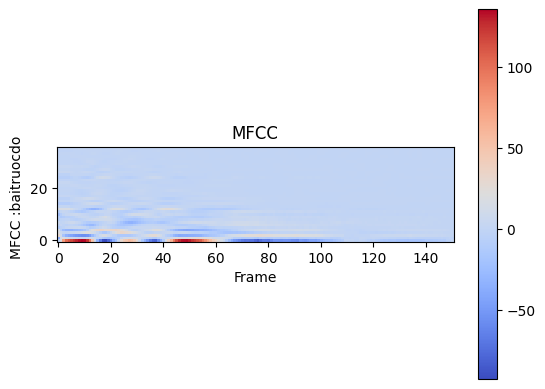

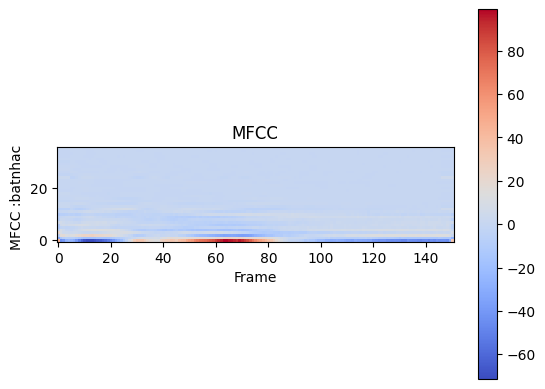

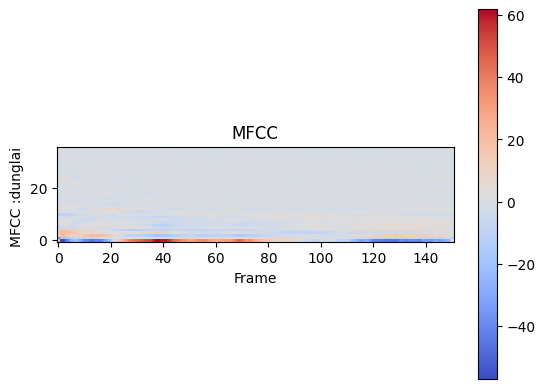

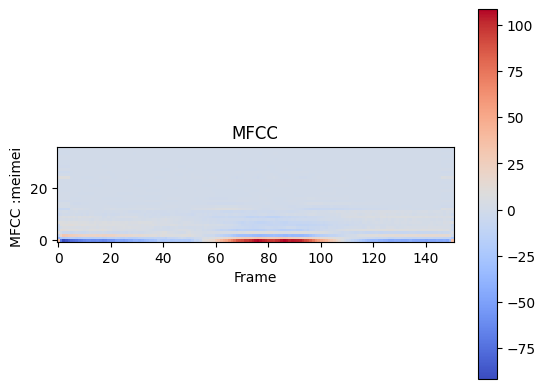

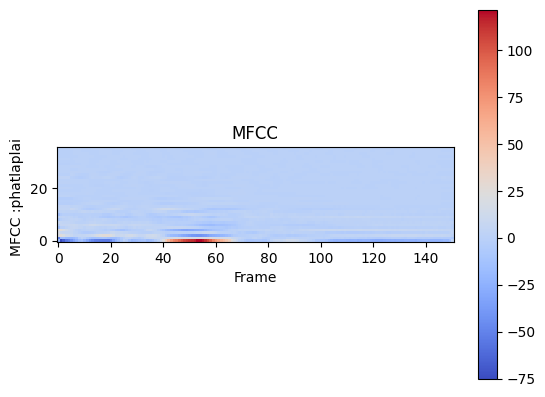

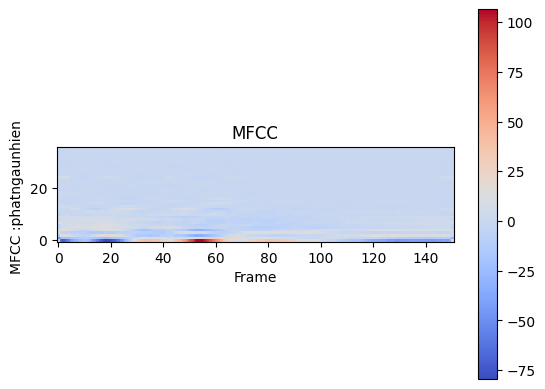

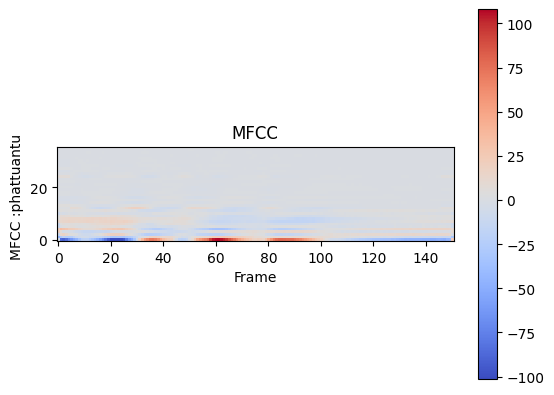

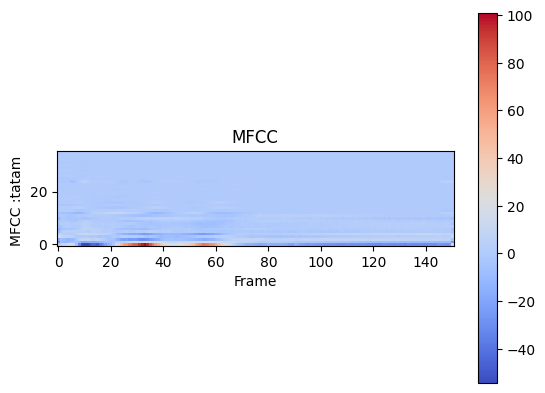

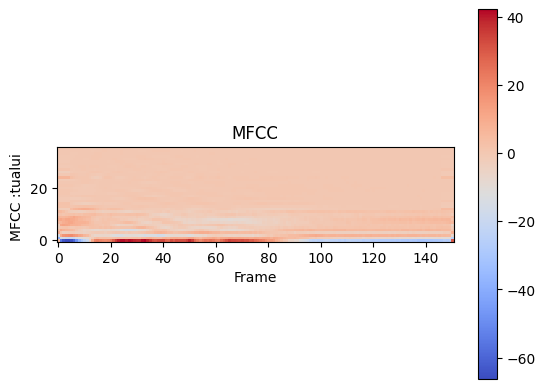

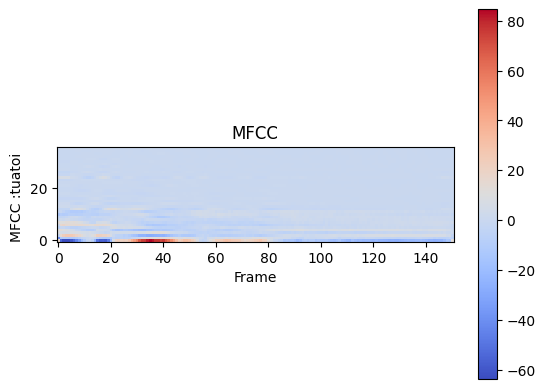

In [7]:
avg_mfcc = {}
for cname in all_data.keys():
    data = all_data[cname]
    padded_mfcc = np.zeros((len(data), max([d.shape[0] for d in data]), 36))
    for i in range(len(data)):
        mfcc = data[i]
        padded_mfcc[i, :mfcc.shape[0], :] = mfcc
    avg_mfcc[cname] = np.mean(padded_mfcc, axis=0)
for cname in class_names:
    #print(f'Label: {cname} Average MFCC: {avg_mfcc[cname]}' )
    plt.imshow(avg_mfcc[cname].T, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    plt.title('MFCC')
    plt.xlabel('Frame')
    plt.ylabel(f'MFCC :{cname} ')
    plt.colorbar()
    plt.show()

amluongmottram train: 47 | test: 21
amluongnammuoi train: 51 | test: 22
baitieptheo train: 37 | test: 16
baitruocdo train: 41 | test: 18
batnhac train: 48 | test: 21
dunglai train: 40 | test: 18
meimei train: 39 | test: 18
phatlaplai train: 51 | test: 22
phatngaunhien train: 46 | test: 21
phattuantu train: 44 | test: 19
tatam train: 52 | test: 23
tualui train: 44 | test: 20
tuatoi train: 39 | test: 17
train samples: 579
test samples 256
amluongmottram
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -598280.51616972             +nan
         2 -570092.12044619  +28188.39572353
         3 -563386.76330680   +6705.35713939
         4 -557669.22718069   +5717.53612611
         5 -556862.49523058    +806.73195012
         6 -556559.46877799    +303.02645259
         7 -556291.18238316    +268.28639483
         8 -556014.05468269    +277.12770047
         9 -555724.94015389    +289.11452880
        10 -555440.09438777    +284.84576612
        11 -555234.18235950    +205.91202827
        12 -555135.49177358     +98.69058591
        13 -555068.91386699     +66.57790660
        14 -554999.21484543     +69.69902156
        15 -554915.85661606     +83.35822937
        16 -554818.90310973     +96.95350632
        17 -554751.69294071     +67.21016903
        18 -554719.05869397     +32.63424673
        19 -554702.65141222     +16.40728175
        20 -554693.08859867      +9.56281355
        21 -554686.78950755      +6.29909112
        22 -554681.84584173      +4.94366583
        23

amluongnammuoi
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        10 -648518.84205488    +266.87715500
        11 -648043.88193174    +474.96012314
        12 -647547.87380103    +496.00813071
        13 -647132.64017244    +415.23362859
        14 -646891.98554696    +240.65462548
        15 -646778.58833938    +113.39720758
        16 -646724.12642022     +54.46191916
        17 -646697.83045721     +26.29596301
        18 -646684.35361152     +13.47684569
        19 -646678.03707478      +6.31653673
        20 -646674.89545448      +3.14162031
        21 -646673.04168896      +1.85376552
        22 -646671.77289311      +1.26879585
        23 -646670.81331097      +0.95958214
        24 -646670.02602290      +0.78728807
        25 -646669.32254503      +0.70347787
        26 -646668.62473079      +0.69781425
        27 -646667.83621582      +0.78851497
        28 -646666.83169817      +1.00451765
        29 -646665.58340837      +1.24828980
        30 -646664.31411835      +1.26929002
        31 -646663.14959866      +1.16451969
        32

baitieptheo
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         5 -432801.92377944   +3322.09338911
         6 -431809.55526820    +992.36851124
         7 -431527.74515951    +281.81010869
         8 -431453.39836867     +74.34679084
         9 -431407.47203564     +45.92633303
        10 -431371.90543063     +35.56660501
        11 -431336.06148365     +35.84394698
        12 -431296.93508220     +39.12640145
        13 -431253.58945898     +43.34562322
        14 -431207.66771980     +45.92173918
        15 -431163.38357312     +44.28414668
        16 -431123.00288865     +40.38068446
        17 -431093.73637341     +29.26651525
        18 -431077.67769403     +16.05867937
        19 -431070.56543441      +7.11225962
        20 -431067.70193322      +2.86350120
        21 -431066.53112002      +1.17081320
        22 -431066.03218926      +0.49893076
        23 -431065.81501386      +0.21717541
        24 -431065.72027269      +0.09474117
        25 -431065.67917940      +0.04109329
        26 -431065.66148431      +0.01769508
        27

baitruocdo
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        20 -416356.98268462      +1.91789699
        21 -416355.96467744      +1.01800717
        22 -416355.45300170      +0.51167575
        23 -416355.18895493      +0.26404676
        24 -416355.04875346      +0.14020147
        25 -416354.97303886      +0.07571461
        26 -416354.93181420      +0.04122466
        27 -416354.90929397      +0.02252023
        28 -416354.89697960      +0.01231437
        29 -416354.89024586      +0.00673374
         1 -638738.34142903             +nan
         2 -585500.00148688  +53238.33994215
         3 -568147.27129100  +17352.73019588
         4 -561959.03655954   +6188.23473146
         5 -559802.97909668   +2156.05746286
         6 -559612.92994266    +190.04915402
         7 -559576.03689388     +36.89304878


batnhac
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         8 -559539.64119546     +36.39569842
         9 -559509.33181206     +30.30938340
        10 -559497.89008664     +11.44172542
        11 -559493.45739047      +4.43269618
        12 -559491.40335755      +2.05403292
        13 -559490.12544175      +1.27791581
        14 -559489.03871957      +1.08672218
        15 -559487.94279326      +1.09592631
        16 -559486.82966412      +1.11312914
        17 -559485.84575393      +0.98391019
        18 -559485.17606611      +0.66968782
        19 -559484.83439279      +0.34167332
        20 -559484.68787848      +0.14651431
        21 -559484.62830508      +0.05957340
        22 -559484.60417027      +0.02413481
        23 -559484.59432021      +0.00985006
         1 -484065.79452215             +nan
         2 -444665.82052135  +39399.97400080
         3 -434122.45906052  +10543.36146083
         4 -431638.78186628   +2483.67719424
         5 -430148.78632008   +1489.99554620
         6 -428832.41564055   +1316.37067953
         7

dunglai
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        16 -426789.24245570    +606.55279872
        17 -426147.80826385    +641.43419185
        18 -425655.97890837    +491.82935548
        19 -425101.79329483    +554.18561354
        20 -424674.12292489    +427.67036994
        21 -424044.77061927    +629.35230562
        22 -423711.90727543    +332.86334384
        23 -423468.41846076    +243.48881468
        24 -423284.17543069    +184.24303006
        25 -423183.68554349    +100.48988720
        26 -423130.30328734     +53.38225615
        27 -423112.32187807     +17.98140927
        28 -423106.70602428      +5.61585379
        29 -423105.24789575      +1.45812853
        30 -423104.47622019      +0.77167556
        31 -423103.98366957      +0.49255062
        32 -423103.65610636      +0.32756321
        33 -423103.38655024      +0.26955612
        34 -423103.13296768      +0.25358256
        35 -423102.90790517      +0.22506251
        36 -423102.74742431      +0.16048086
        37 -423102.65644642      +0.09097789
        38

meimei
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        17 -448700.31452401      +7.82022478
        18 -448695.01529800      +5.29922601
        19 -448690.86455807      +4.15073993
        20 -448686.52170357      +4.34285450
        21 -448682.51213470      +4.00956887
        22 -448679.61719614      +2.89493856
        23 -448677.42012966      +2.19706648
        24 -448675.69629522      +1.72383444
        25 -448674.33726320      +1.35903202
        26 -448673.17179294      +1.16547025
        27 -448672.06085484      +1.11093810
        28 -448670.92365335      +1.13720149
        29 -448669.66147991      +1.26217345
        30 -448668.05057596      +1.61090394
        31 -448665.58969858      +2.46087738
        32 -448661.54097216      +4.04872642
        33 -448656.85242423      +4.68854793
        34 -448654.26451896      +2.58790528
        35 -448653.33088997      +0.93362899
        36 -448653.05062597      +0.28026400
        37 -448652.97990162      +0.07072435
        38 -448652.96205201      +0.01784961
        39

phatlaplai
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -561897.84781626             +nan
         2 -539286.89099091  +22610.95682536
         3 -537574.12512865   +1712.76586226
         4 -536840.95422641    +733.17090224
         5 -536505.00321191    +335.95101450
         6 -536313.46546970    +191.53774221
         7 -536148.00979112    +165.45567858
         8 -535995.39026315    +152.61952797
         9 -535799.43901428    +195.95124887
        10 -535431.40407984    +368.03493444
        11 -534588.15305370    +843.25102615
        12 -532433.89561369   +2154.25744000
        13 -529228.38762297   +3205.50799072
        14 -527973.20932312   +1255.17829985
        15 -527679.52896658    +293.68035654
        16 -527533.52188082    +146.00708576
        17 -527469.26257468     +64.25930615
        18 -527459.30371986      +9.95885482
        19 -527406.25096245     +53.05275741
        20 -527304.19508138    +102.05588106
        21 -527160.93886065    +143.25622073
        22 -526651.24931530    +509.68954535
        23

phatngaunhien
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         6 -571464.19205126    +764.22812595
         7 -570899.44698706    +564.74506420
         8 -570714.13167700    +185.31531007
         9 -570663.60526332     +50.52641368
        10 -570642.46236678     +21.14289654
        11 -570635.64421604      +6.81815074
        12 -570634.23837446      +1.40584157
        13 -570633.64710967      +0.59126479
        14 -570633.46576099      +0.18134868
        15 -570633.56156018      -0.09579919
Model is not converging.  Current: -570633.5615601772 is not greater than -570633.4657609866. Delta is -0.09579919069074094
         1 -573896.51812466             +nan
         2 -539875.16342270  +34021.35470196
         3 -533496.72515881   +6378.43826390
         4 -528972.64662885   +4524.07852996
         5 -525992.28966953   +2980.35695932


phattuantu
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         6 -524542.14803722   +1450.14163231
         7 -523706.89226800    +835.25576921
         8 -523490.40240612    +216.48986188
         9 -523448.13503838     +42.26736774
        10 -523439.62738646      +8.50765192
        11 -523436.82195824      +2.80542822
        12 -523435.86310670      +0.95885154
        13 -523435.47440876      +0.38869794
        14 -523435.29617147      +0.17823729
        15 -523435.20899087      +0.08718060
        16 -523435.16498275      +0.04400812
        17 -523435.14242625      +0.02255650
        18 -523435.13075670      +0.01166955
        19 -523435.12466345      +0.00609325
         1 -578198.72208436             +nan
         2 -548175.55351915  +30023.16856521
         3 -534555.27547605  +13620.27804310
         4 -525235.61536835   +9319.66010770
         5 -520979.51565735   +4256.09971100
         6 -518064.05666875   +2915.45898860
         7 -515941.10562603   +2122.95104272
         8 -515328.86088061    +612.24474542
         9

tatam
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        13 -514972.92762520     +48.55782568
        14 -514928.28328600     +44.64433919
        15 -514896.70008507     +31.58320093
        16 -514882.73916311     +13.96092196
        17 -514877.54867865      +5.19048446
        18 -514875.29309417      +2.25558448
        19 -514874.26232332      +1.03077085
        20 -514873.80439998      +0.45792334
        21 -514873.60485656      +0.19954342
        22 -514873.51829975      +0.08655681
        23 -514873.48072457      +0.03757518
        24 -514873.46440557      +0.01631900
        25 -514873.45733688      +0.00706869
         1 -477351.69814160             +nan
         2 -434543.04646544  +42808.65167616
         3 -423364.46762176  +11178.57884368
         4 -420707.85551025   +2656.61211151
         5 -420029.41757800    +678.43793225
         6 -419822.13594057    +207.28163744
         7 -419751.77837465     +70.35756591
         8 -419729.40201445     +22.37636021
         9 -419714.23322760     +15.16878685
        10

tualui
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        12 -419690.02558730      +6.85019384
        13 -419679.57098096     +10.45460634
        14 -419670.72593137      +8.84504959
        15 -419659.43835222     +11.28757915
        16 -419637.70585121     +21.73250101
        17 -419617.17070034     +20.53515088
        18 -419596.03541411     +21.13528622
        19 -419585.93961211     +10.09580201
        20 -419582.11926648      +3.82034562
        21 -419579.53463931      +2.58462717
        22 -419578.04776705      +1.48687226
        23 -419577.33608285      +0.71168420
        24 -419576.96075932      +0.37532352
        25 -419576.75289817      +0.20786116
        26 -419576.63520159      +0.11769658
        27 -419576.56792256      +0.06727902
        28 -419576.52936090      +0.03856166
        29 -419576.50726849      +0.02209241
        30 -419576.49462732      +0.01264117
        31 -419576.48739986      +0.00722745
         1 -444914.20591012             +nan
         2 -420024.05696103  +24890.14894909
         3

tuatoi
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        13 -400962.15155864     +86.84981269
        14 -400626.31999125    +335.83156739
        15 -400276.08808783    +350.23190342
        16 -400241.13972916     +34.94835867
        17 -400215.59037742     +25.54935174
        18 -400179.29010398     +36.30027344
        19 -400113.98239668     +65.30770730
        20 -399961.59616503    +152.38623166
        21 -399680.20631515    +281.38984987
        22 -399508.28995362    +171.91636153
        23 -399441.51770802     +66.77224559
        24 -399407.77183022     +33.74587781
        25 -399401.03233634      +6.73949387
        26 -399400.10670959      +0.92562675
        27 -399400.01063086      +0.09607874
        28 -399399.97929916      +0.03133170
        29 -399399.96039797      +0.01890119
        30 -399399.94687009      +0.01352788
        31 -399399.93633279      +0.01053730
        32 -399399.92772651      +0.00860628


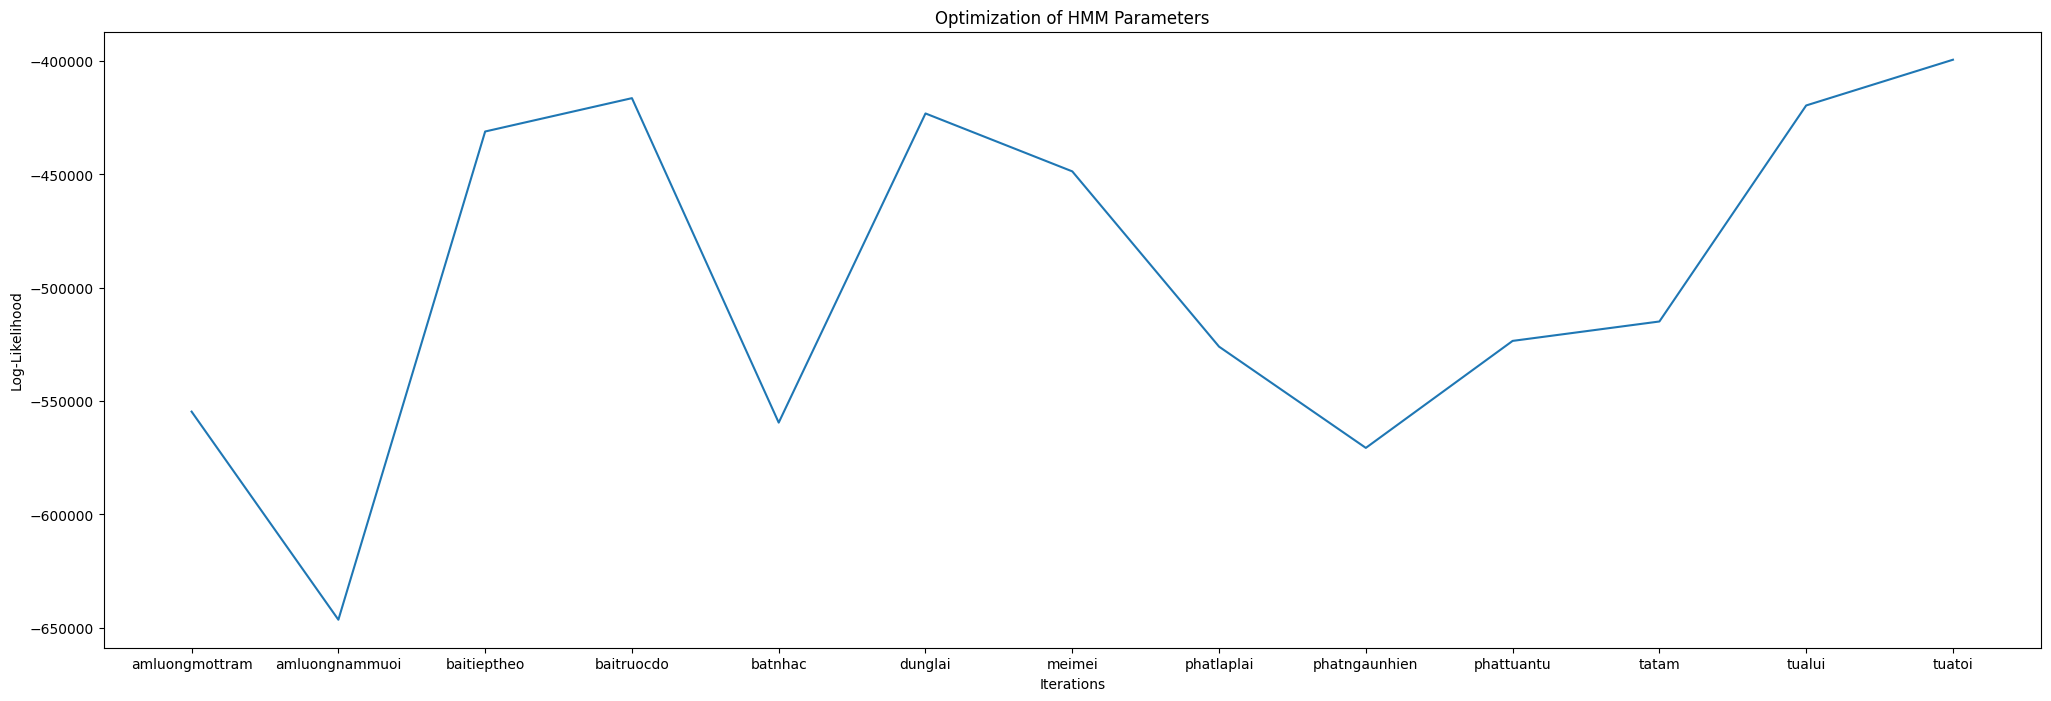

In [8]:
for cname in class_names:
    log_likelihoods = []


    x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.3,
            random_state=1
        )

    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

total_train = 0
total_test = 0
for cname in class_names:
    train_count = len(X['train'][cname])
    test_count = len(X['test'][cname])
    print(cname, 'train:', train_count, '| test:', test_count)
    total_train += train_count
    total_test += test_count
print('train samples:', total_train)
print('test samples', total_test)

for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0

            
    print(cname)
    print(trans_matrix)

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx],
        verbose=True,
        n_iter=300,
        startprob_prior=start_prob,
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='stmc',
        random_state=0
    )     
    model[cname].fit(X=np.vstack(X['train'][cname]),
        lengths=[x.shape[0] for x in X['train'][cname]])
    log_likelihoods.append(model[cname].score(X=np.vstack(X['train'][cname]),
                                              lengths=[x.shape[0] for x in X['train'][cname]]))
plt.figure(figsize=(25,8))
plt.plot(range(len(class_names)), log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.xticks(range(len(class_names)), class_names)
plt.title('Optimization of HMM Parameters')
plt.show()

                        
for cname in class_names:
    name = f'{model_path}/model_{cname}.pkl'
    with open(name, 'wb') as file:
        pickle.dump(model[cname], file)

amluongmottram: 1.0
amluongnammuoi: 1.0
baitieptheo: 0.9661016949152542
baitruocdo: 0.935064935064935
batnhac: 0.9183673469387755
dunglai: 0.9224137931034483
meimei: 0.9253731343283582
phatlaplai: 0.9230769230769231
phatngaunhien: 0.9209039548022598
phattuantu: 0.9285714285714286
tatam: 0.8949771689497716
tualui: 0.899581589958159
tuatoi: 0.90625


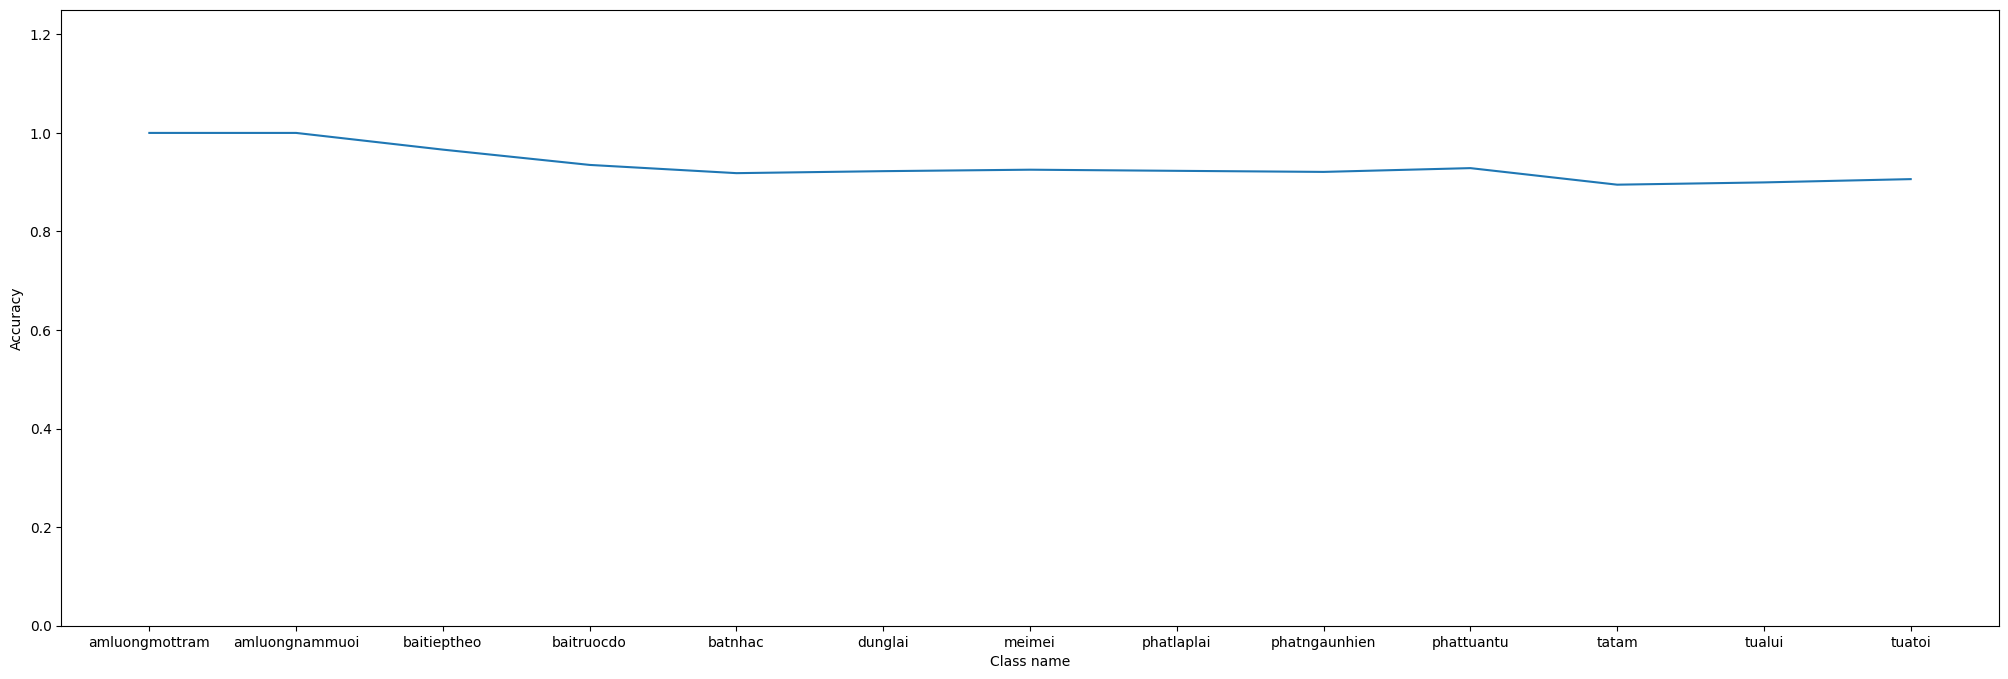

In [9]:
y_true = []
y_pred = []
accuracies = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
    accuracies.append(accuracy)
    print(f'{cname}:', accuracy)

plt.figure(figsize=(25,8))
plt.plot(class_names, accuracies)
plt.xlabel('Class name')
plt.ylabel('Accuracy')
plt.ylim([0, 1.25])
plt.show()


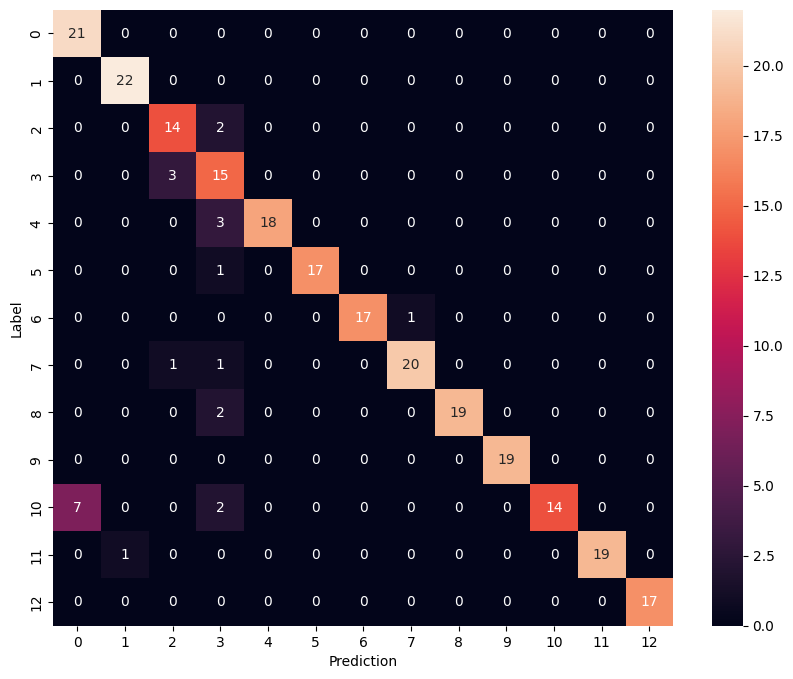

In [10]:
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [11]:
report = classification_report( y_pred,y_true, target_names=class_names)
print(report)

                precision    recall  f1-score   support

amluongmottram       1.00      0.75      0.86        28
amluongnammuoi       1.00      0.96      0.98        23
   baitieptheo       0.88      0.78      0.82        18
    baitruocdo       0.83      0.58      0.68        26
       batnhac       0.86      1.00      0.92        18
       dunglai       0.94      1.00      0.97        17
        meimei       0.94      1.00      0.97        17
    phatlaplai       0.91      0.95      0.93        21
 phatngaunhien       0.90      1.00      0.95        19
    phattuantu       1.00      1.00      1.00        19
         tatam       0.61      1.00      0.76        14
        tualui       0.95      1.00      0.97        19
        tuatoi       1.00      1.00      1.00        17

      accuracy                           0.91       256
     macro avg       0.91      0.92      0.91       256
  weighted avg       0.92      0.91      0.90       256

